In [71]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import datetime as dt
import multiprocessing
import folium
import branca
import branca.colormap as cm
import pylab
import random as rd
import timeit
import json

from scipy.stats import truncnorm
from tqdm.notebook import tqdm
from collections import Counter
from folium.plugins import HeatMap
from folium.features import DivIcon
from numba import jit

# Single machine progress bar
from dask.diagnostics import ProgressBar

#Define display parameters
pd.options.display.precision = 2
#pd.set_option('display.max_columns', None)
nbRowsToDisplay = 1000
pd.options.display.min_rows = nbRowsToDisplay
pd.options.display.max_rows = nbRowsToDisplay
pd.options.display.float_format = '{:,.2f}'.format

In [72]:
def computeHistogram(values):
    c=Counter(values)
    counts = list(c.values())
    labels = list(c.keys())
    
    return counts, labels

def plotHistogram(counts,labels,tit,xlab,ylab):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    counts=counts/np.sum(counts)
    ax.bar(labels, counts, align='center')
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)
    
#Define a plot histrogram function
def plotContinuousHist(serie,nbBins,tit,xlab,ylab):
    #Distribution of trip duration
    df = pd.DataFrame(serie)
    df.hist(bins=nbBins,figsize=(20,10))
    plt.title(tit,fontsize=18)
    plt.xlabel(xlab,fontsize=18)
    plt.ylabel(ylab,fontsize=18)
    
#Define a scatter plot function
def scatterPlot(x,y,tit,xlab,ylab):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)

In [73]:
# Vectorized haversine function to calculate distances
#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def haversineDf1(df,startLat,startLong,endLat,endLong):
    Lat = [np.nan]
    Lat[1:] = df[startLat][1:]
    Long = [np.nan]
    Long[1:] = df[startLong][1:]
    dist = haversine(df[endLat].shift(), df[endLong].shift(),Lat, Long)
    
    #dist = haversine(df.latitude.shift()[1:], df.longitude.shift()[1:],df.loc[1:,'latitude'], df.loc[1:,'longitude'])
    
    return dist #np.insert(dist,0,0)

In [74]:
#Define a function to display an heatmap
Cph_Lat = 12.5683
Cph_Long = 55.6761

#Create a gradient map
steps = 20
color_map=cm.linear.Reds_04.scale(0,1).to_step(steps)
gradient_map={}
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

def generateBaseMap(default_location=[Cph_Long, Cph_Lat], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

def plotHistmap(lat,long):
    df_c = pd.DataFrame({'latitude':lat,'longitude':long})
    df_c.loc[:,'count'] = 1
    
    heatmap = generateBaseMap() #Base map
    #Heat map
    heatmap.add_child(HeatMap(data=df_c.loc[:,['latitude', 'longitude', 'count']].\
            groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), 
                              radius=13, max_zoom=5,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

In [75]:
#Define a function that plots the end battery level and the minutes between trips
def plotEndBatteryAndMinutesBetweenTripsDistribution(df,endBatteryLvl,endTripSoC,minutesAfterTrip,\
                                                     chargeDoneAfterTrip,increaseInSoC):
    # Have a look at the end battery level before charging
    print('The trips end with negative battery level for',
          round(len(df[df[endBatteryLvl] < 0])/len(df)*100,2),'% trips') 
    fig, axes = plt.subplots(nrows=4, ncols=1)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    #Distribution of end battery level
    ax0 = axes[0]
    (df[endTripSoC]).hist(bins=100,ax=ax0)
    ax0.set_xlabel("End trip SoC",fontsize=18)
    ax0.set_ylabel("Trip count",fontsize=18)
    #ax0.set_title('Distribution of end trip battery level',fontsize=18)

    #Distribution of SoC when charging
    ax3 = axes[1]
    df[df[chargeDoneAfterTrip]==1][endTripSoC].hist(bins=100,ax=ax3)
    ax3.set_xlabel("End trip SoC before charging",fontsize=18)
    ax3.set_ylabel("Trip count",fontsize=18)
    #ax3.set_title('Distribution of end trip Soc before charging',fontsize=18)
    
    #Distribution of minutes between trip when charging
    ax1= axes[2]
    df[(df[chargeDoneAfterTrip]==1)&(df[minutesAfterTrip]<1000)][minutesAfterTrip].hist(bins=100,ax=ax1)
    ax1.set_xlabel("Minutes before next trip when charging",fontsize=18)
    ax1.set_ylabel("Trip count",fontsize=18)
    #ax1.set_title('Distribution of minutes between trips when charging',fontsize=18)
    
    #Distribution of charge
    ax2= axes[3]
    df[(df[chargeDoneAfterTrip]==1)][increaseInSoC].hist(bins=100,ax=ax2)
    ax2.set_xlabel("Increase in SoC",fontsize=18)
    ax2.set_ylabel("Trip count",fontsize=18)
    #ax2.set_title('Distribution of energy charged',fontsize=18)

In [76]:
#Build a truncated normal distribution such as values below myclip_a 
#are transformed to myclip_a  and values above myclip_b are assigned to myclip_b value
def samplesFromTruncatedNormalDistribution(myclip_a,my_mean,myclip_b,my_std,nbSamp,displayDistrib):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x = np.linspace(myclip_a-0.5,myclip_b-0.5,1000)
    samples = truncnorm.rvs(a, b, loc = my_mean, scale = my_std, size=nbSamp)
    
    #To verify that the sampled values corresponds to the normal distribution
    if displayDistrib == True:
        df = pd.DataFrame(samples)
        df.hist(bins=100,figsize=(20,10), density=True)
        plt.plot(x,truncnorm.pdf(x,a, b, loc = my_mean, scale = my_std))
    
    return samples

In [77]:
def computeHistogram(values):
    c=Counter(values)
    counts = list(c.values())
    labels = list(c.keys())
    
    return counts, labels

def plotHistogram(counts,labels,tit,xlab,ylab,width=0.8):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    ax.bar(labels, counts, align='center',width=width)
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)
    
#Define a plot histrogram function
def plotContinuousHist(serie,nbBins,tit,xlab,ylab,width=0.8):
    #Distribution of trip duration
    df = pd.DataFrame(serie)
    df.hist(bins=nbBins,figsize=(20,10),density = True)
    plt.title(tit,fontsize=18)
    plt.xlabel(xlab,fontsize=18)
    plt.ylabel(ylab,fontsize=18)
    
#Define a scatter plot function
def scatterPlot(x,y,tit,xlab,ylab):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)

In [78]:
fileDirectory = '/mnt/sdb1/gauthier/jupyter/'

# Run the experiment

### Prepare the distributions from which input parameters are sampled

For each realisation, input parameters are sampled from distributions. The distributions are described here:

- Init charge average: truncated normal distribution with mean = 40%
- longBreakMinutes: truncated normal distribution with mean = 200 min 
- shortBreakMinutes: truncated normal distribution with mean = 30min 
- emergencySoC: uniform distribution between 10% and 20%
- SoCForShortChargeBreak: truncated normal distribution with mean = 30%
- SoCForLongChargeBreak: truncated normal distribution with mean = 40%


- fuelToEnergyRatio: truncated normal distribution with mean = 2 kWh/l
- batteryCapacity: defined accordingly to the battery capacities of top 10 models sold in Denmark
- chargeSpeedByMinute: defined accordingly to the charging station types distribution in Denmark

In [79]:
df = pd.read_pickle(fileDirectory+"data/DataModeling_Iteration4/tripStartEndPoints_Preparation2.pkl")
#df = df[:10000]
df = df.reset_index()

In [80]:
df.columns

Index(['index', 'carId', 'gpsRecordedAtCETStart', 'tripStartDate', 'tripId',
       'brand', 'model', 'engineSizeLiters', 'fuelType', 'year', 'carSegment',
       'startLongitude', 'startLatitude', 'gpsSpeedFromUnit',
       'gpsDirectionFromUnit', 'tripDriveDurationInMinutes',
       'tripEstimateFuelUsedInLiters', 'tripIdleTimeInSeconds', 'endLatitude',
       'endLongitude', 'gpsRecordedAtCETEnd', 'totalTravelDistanceInKm',
       'distancesInKm_endStart', 'closeConsecutiveTrips',
       'minutesBetweenTrips', 'newCarId', 'closeConsecutiveTrips_adj',
       'lowTimeGap_adj', 'fuelUsedInLitersBy100Km'],
      dtype='object')

In [100]:
#Define a seed
rd.seed(654321)

#Build distributions to sample initSoc average, SoCForLongChargeBreak average, longBreakInMinutes, 
#shortBreakInMinutes, fuelToEnergyRatio, SoCForShortChargeBreak
nbSamples = 1000000
shortBreakInMinutes = samplesFromTruncatedNormalDistribution(0,30,1000,10,nbSamples,False)
longBreakInMinutes = samplesFromTruncatedNormalDistribution(0,200,1000,45,nbSamples,False)
initSoCAvg = samplesFromTruncatedNormalDistribution(0.2,0.4,0.8,0.1,nbSamples,False)
emergencySoC = np.random.uniform(low=0.1, high=0.2, size=nbSamples)
SoCForShortChargeBreak = samplesFromTruncatedNormalDistribution(0.2,0.4,0.8,0.05,nbSamples,False)
SoCForLongChargeBreakAvg = samplesFromTruncatedNormalDistribution(0.2,0.6,0.8,0.1,nbSamples,False)
fuelToEnergyRatio = samplesFromTruncatedNormalDistribution(0.5,2,3.5,0.5,nbSamples,False)

#Build the battery capacity distribution from the battery capacity of the top 10 EV model sales in Denmark
nbCars = len(df.carId.unique()) 
batteryCapacity = [50, 75, 45, 58, 77, 64, 64, 52, 32, 40, 62, 71, 95, 19, 79.2, 93.4]
batteryOcc = np.array([4277/2, 4277/2, 1722/3, 1722/3, 1722/3, 1160, 834, 710, 625, 566/2, 566/2,
                 493/2, 493/2, 369, 327/2, 327/2])
batteryProbabilities = batteryOcc/np.sum(batteryOcc)
batteryDistrib = np.random.choice(batteryCapacity, nbCars, p=batteryProbabilities)

#speed charge on slow chargers in KWh/ hour
slowChargersChargeSpeed = np.array([40, 75, 13.8])/np.array([6, 5 ,4])
print("Slow chargers charge speed:",slowChargersChargeSpeed)

#speed charge on fast chargers in KWh/ hour
fastChargersChargeSpeed= np.array([40, 75, 13.8])/np.array([1, 2 ,0.4])
print("Fast chargers charge speed:",fastChargersChargeSpeed)

#Compute the speed charge by minute
#For slow chargers, speed charge = 7 kWh /hour
#For fast chargers, speed charge = 37.5 kWh /hour
chargeSpeedByMinute = np.array([37.5,7])/60
chargersProba = np.array([550,2699])/(((550+2699)))

Slow chargers charge speed: [ 6.66666667 15.          3.45      ]
Fast chargers charge speed: [40.  37.5 34.5]


# Plot histogram of the distributions

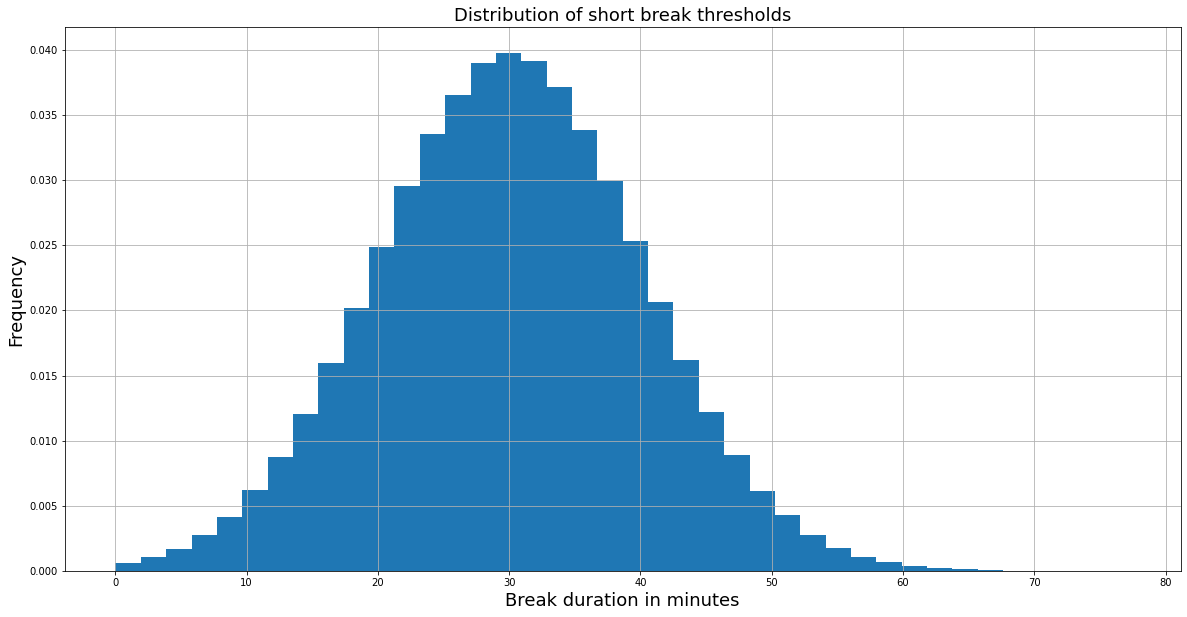

In [101]:
plotContinuousHist(shortBreakInMinutes,40,'Distribution of short break thresholds','Break duration in minutes',
                   'Frequency')

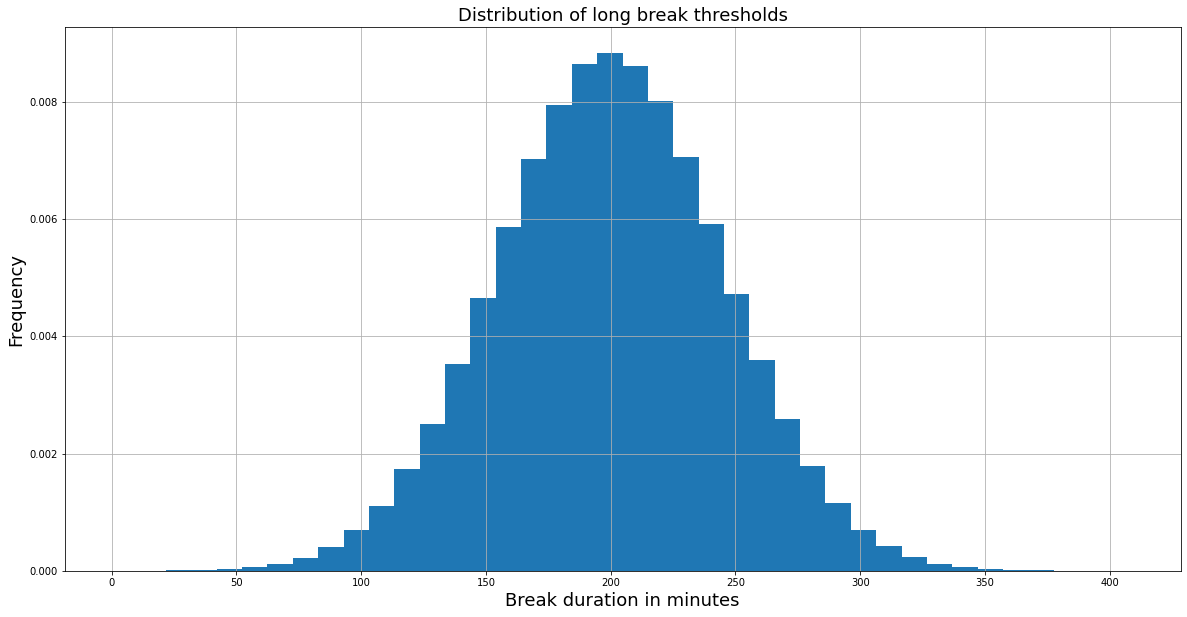

In [102]:
plotContinuousHist(longBreakInMinutes,40,'Distribution of long break thresholds','Break duration in minutes',
                   'Frequency')

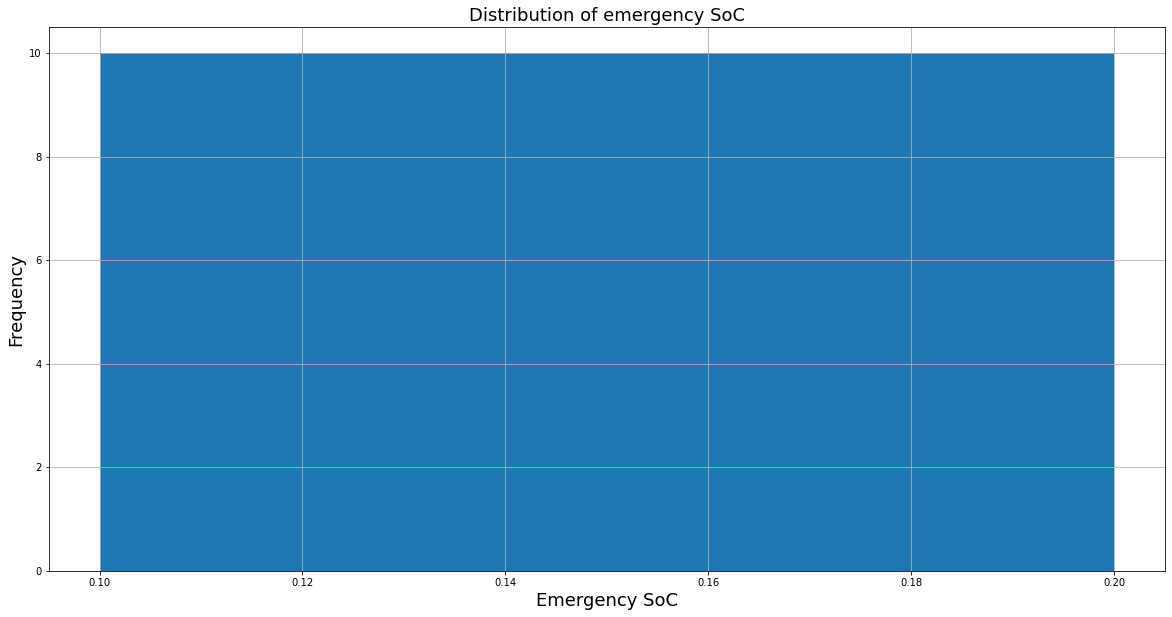

In [103]:
plotContinuousHist(emergencySoC,1,'Distribution of emergency SoC','Emergency SoC',
                   'Frequency')

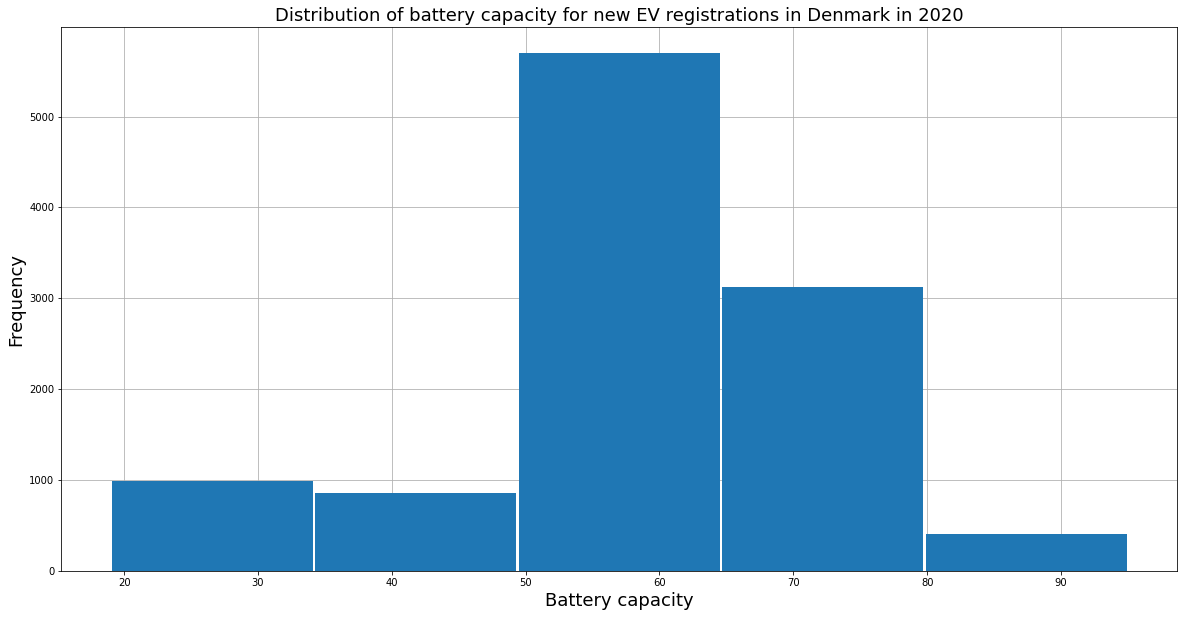

In [104]:
hist, bins = np.histogram(np.repeat(batteryCapacity,batteryOcc.astype('int')),bins=5)
bins=(bins[:-1]+bins[1:])/2
plotHistogram(hist,bins,'Distribution of battery capacity for new EV registrations in Denmark in 2020',
              'Battery capacity','Frequency',15)

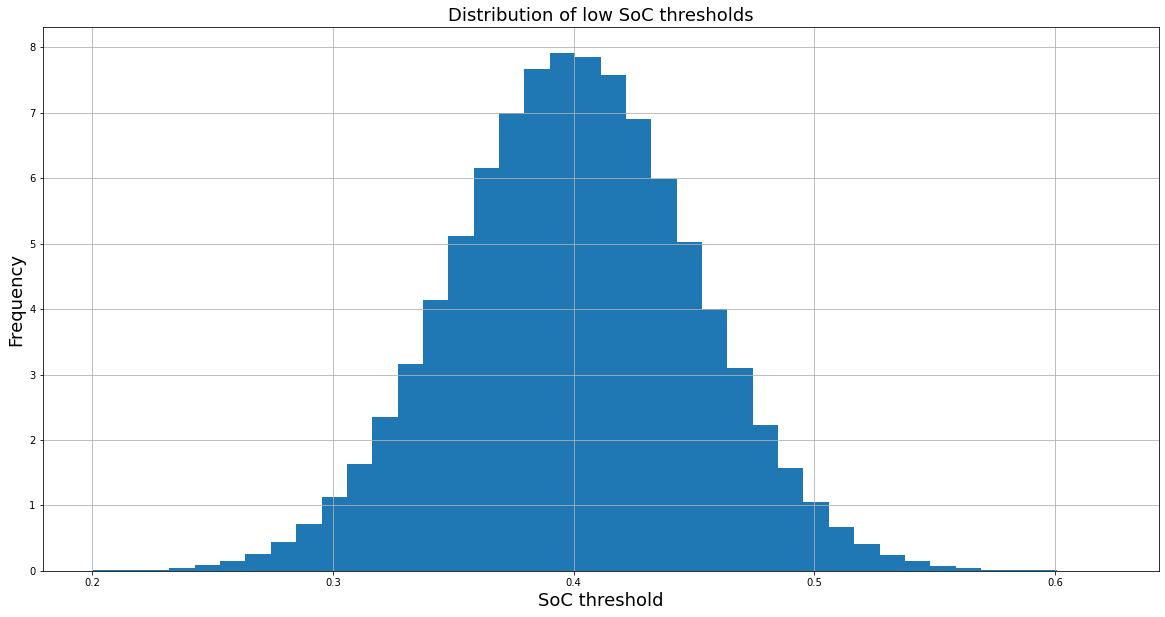

In [105]:
plotContinuousHist(SoCForShortChargeBreak,40,'Distribution of low SoC thresholds','SoC threshold',
                   'Frequency')

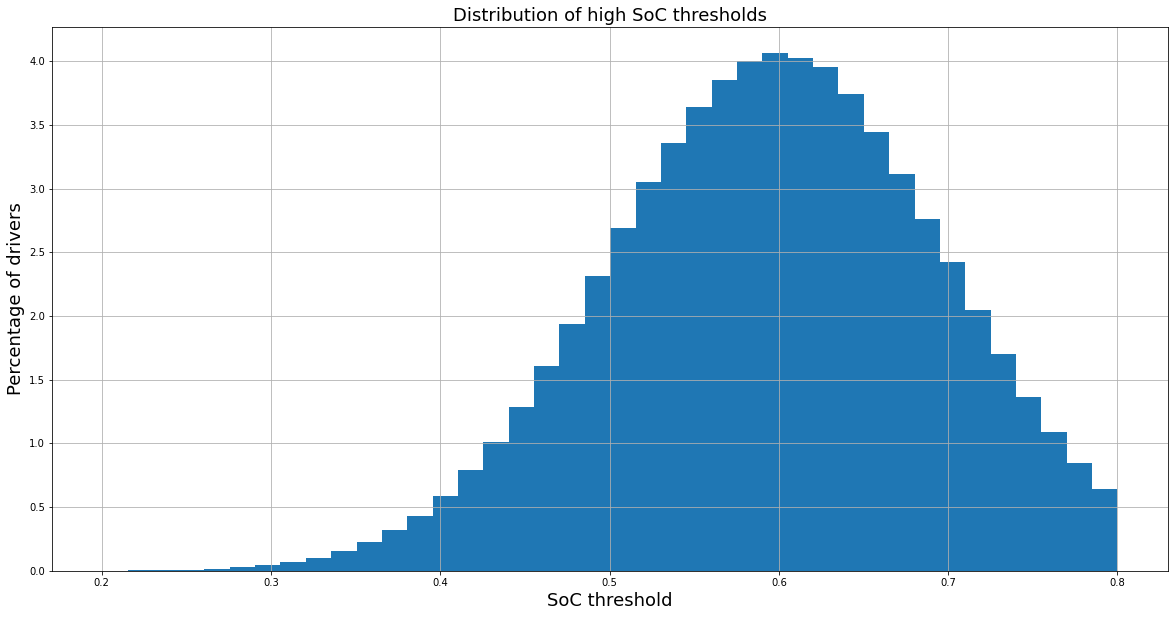

In [106]:
plotContinuousHist(SoCForLongChargeBreakAvg,40,'Distribution of high SoC thresholds','SoC threshold',
                   'Percentage of drivers')

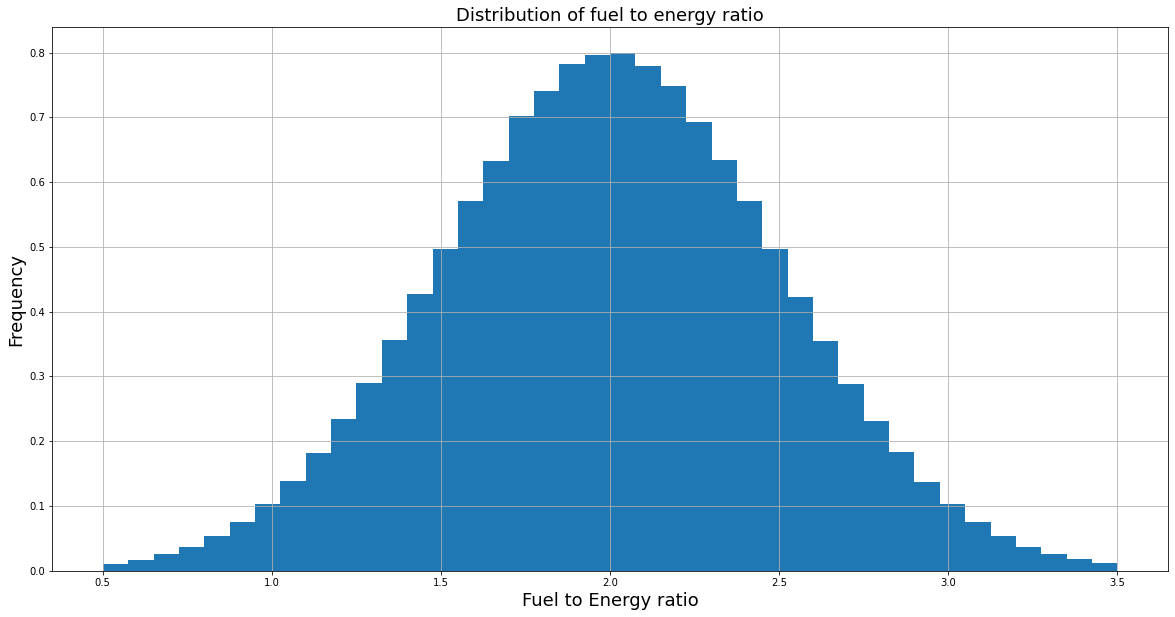

In [107]:
plotContinuousHist(fuelToEnergyRatio,40,'Distribution of fuel to energy ratio','Fuel to Energy ratio',
                   'Frequency')

# Simulation

In [48]:
df = pd.read_pickle("data/DataModeling_Iteration4/tripStartEndPoints_Preparation2.pkl")
df = df.reset_index()

In [49]:
nbCars = len(df.carId.unique()) 
nbTrips = len(df)

In [52]:
#Try to use numpy vectors
#Define vectors
df['index'] = range(nbTrips)
carId = df.carId.values
uniqueCarIds =  df.carId.unique()
newCarId = df.newCarId.values
index = df['index'].values #Get the index
firstIndexCar = newCarId * index #Get the first index for each car
tripEstimateFuelUsedInLiters = df.tripEstimateFuelUsedInLiters.values

#Conditions to charge
#Compute minutes after trips
minutesAfterTrip = ((df.gpsRecordedAtCETStart.shift(-1) - df.gpsRecordedAtCETEnd) / np.timedelta64(1, "m")).values
#Set minutes after trip for the last trip to 480min
lastCarId = np.concatenate((newCarId[1:],np.array([1])))

#Get the number of trips by car - useful for creating numpy arrays for batteryCapacity, ..
nbTripsByCar = df[['carId','index']].groupby('carId').count().values
nbTripsByCar = nbTripsByCar.flatten()

In [53]:
def computeExperiment(df,c,longBreakInMinutes,shortBreakInMinutes,fuelToEnergyRatio,SoCForShortChargeBreak,emergencySoC,
                     uniqueCarIds,initSoCAvg,SoCForLongChargeBreakAvg,batteryDistrib,chargersProba,nbTripsByCar,
                     carId,nbCars,nbTrips,chargeSpeedByMinute,lastCarId,minutesAfterTrip,tripEstimateFuelUsedInLiters):

    df_c = df
    
    #Get a sampled input parameter from the previously defined distributions
    longBreakInMinutes_c = longBreakInMinutes[c]
    shortBreakInMinutes_c = shortBreakInMinutes[c]
    fuelToEnergyRatio_c = fuelToEnergyRatio[c]
    SoCForShortChargeBreak_c = SoCForShortChargeBreak[c]
    emergencySoC_c = emergencySoC[c]

    initSoCAvg_c = initSoCAvg[c]
    SoCForLongChargeBreakAvg_c = SoCForLongChargeBreakAvg[c]
    
    batteryDistrib_c = batteryDistrib #This distribution is constant through replications
    chargersProba_c = chargersProba #This distribution is constant through replications
    
    initSoC = np.repeat(np.random.triangular(initSoCAvg_c -0.20, initSoCAvg_c, initSoCAvg_c +0.20, nbCars),nbTripsByCar)
    batteryCapacity = np.repeat(batteryDistrib_c,nbTripsByCar)
    SoCForLongChargeBreak = np.repeat(np.random.triangular(SoCForLongChargeBreakAvg_c-0.2, 
                                    SoCForLongChargeBreakAvg_c, SoCForLongChargeBreakAvg_c+0.2, nbCars),nbTripsByCar)
    
    
    #Get estimate used energy 
    tripEstimateEnergyUsedInkWh = tripEstimateFuelUsedInLiters * fuelToEnergyRatio_c

    #Add the speed charge by minute for each trip
    chargeSpeedByMinute_c = np.random.choice(chargeSpeedByMinute, nbTrips, p=chargersProba_c)
    
    #Get the energy threshold under which charge is allowed
    batteryCapacity = batteryCapacity
    energyThresholdLongChargeBreak = SoCForLongChargeBreak * batteryCapacity
    energyThresholdShortChargeBreak = SoCForShortChargeBreak_c * batteryCapacity
    
    startBatteryLvl = initSoC * batteryCapacity * newCarId
    startBatteryLvl_init = startBatteryLvl

    #Conditions to charge
    #Assign a sampled value for the minutes after trip for the last trip of each car
    minutesAfterTrip = np.where(lastCarId==1,np.random.triangular(0, 480, 960, nbTrips),minutesAfterTrip)

    #Compute the maximum end trip level of energy that permits to charge for each trip
    maxEnergyLvlToChargeAfterTrip = np.maximum.reduce([
                            (minutesAfterTrip>longBreakInMinutes_c) * energyThresholdLongChargeBreak,
                            (minutesAfterTrip > shortBreakInMinutes_c) * energyThresholdShortChargeBreak,
                            emergencySoC_c*batteryCapacity])

    maxEnergyThatCanBeChargedAfterTrip = chargeSpeedByMinute_c *  minutesAfterTrip

    #Calculate the energy level for each trip only considering the charge and use for the trip
    endTripEnergyLvl_afterCharge = startBatteryLvl_init - tripEstimateEnergyUsedInkWh
    
    endTripEnergyLvl_afterCharge = computeEndTripEnergyLvl(nbTrips,firstIndexCar,endTripEnergyLvl_afterCharge,
                        maxEnergyLvlToChargeAfterTrip,maxEnergyThatCanBeChargedAfterTrip,batteryCapacity)

    
    #Get the energy charged after each trip
    energyChargedAfterTrip = endTripEnergyLvl_afterCharge \
        - np.concatenate((np.array([0]),endTripEnergyLvl_afterCharge[:-1])) + tripEstimateEnergyUsedInkWh

    #As the previous formula doesn't work for the first trip of a car, update the energy charged for each first trip
    energyChargedAfterTrip = np.where(newCarId == 1, endTripEnergyLvl_afterCharge \
                                      - startBatteryLvl_init + tripEstimateEnergyUsedInkWh ,energyChargedAfterTrip)

    #Get the end battery level before charge
    endTripEnergyLvl_beforeCharge = endTripEnergyLvl_afterCharge - energyChargedAfterTrip
    
    return endTripEnergyLvl_beforeCharge, energyChargedAfterTrip, batteryCapacity, minutesAfterTrip

In [54]:
@jit(nopython=True)
def computeEndTripEnergyLvl(nbTrips,firstIndexCar,endTripEnergyLvl_afterCharge,maxEnergyLvlToChargeAfterTrip,
                           maxEnergyThatCanBeChargedAfterTrip,batteryCapacity):
    for j in range(nbTrips):
        #Get the current battery level at the end of the trip without considering charge
        if j != firstIndexCar[j]:
            endTripEnergyLvl_afterCharge[j] = endTripEnergyLvl_afterCharge[j-1] + endTripEnergyLvl_afterCharge[j] 

        #Charge at the end of the trip if charging criterias are fulfilled
        if endTripEnergyLvl_afterCharge[j] < maxEnergyLvlToChargeAfterTrip[j]:
            endTripEnergyLvl_afterCharge[j] += maxEnergyThatCanBeChargedAfterTrip[j]
            endTripEnergyLvl_afterCharge[j] = min(batteryCapacity[j],endTripEnergyLvl_afterCharge[j])
            
    return endTripEnergyLvl_afterCharge

In [56]:
#Initialise the arrays for storing the distributions
nbBins = 100
hist_endTripSoC = np.zeros(nbBins-1)
hist_endTripSoC_beforeCharging  = np.zeros(nbBins-1)
hist_minutesWhenCharging  = np.zeros(2*nbBins-1)
hist_increaseInSoC  = np.zeros(nbBins-1)

bins_endTripSoC = np.linspace(-4,1,nbBins)
bins_endTripSoC_beforeCharging = np.linspace(-4,1,nbBins)
bins_minutesWhenCharging = np.linspace(0,2000,2*nbBins)
bins_increaseInSoC = np.linspace(0,4,nbBins)


nbIter = 100000
sumDemand = np.zeros((1,nbTrips))
sumSquaredDemand = np.zeros((1,nbTrips))
nbFailedTrips = 0


start = timeit.default_timer() 
for iterNb in range(nbIter):

    #Compute the experiment
    #start_c = timeit.default_timer() 

    endTripEnergyLvl_beforeCharge, energyChargedAfterTrip, batteryCapacity, minutesAfterTrip = \
    computeExperiment(df,iterNb,longBreakInMinutes,shortBreakInMinutes,fuelToEnergyRatio,SoCForShortChargeBreak,emergencySoC,
                         uniqueCarIds,initSoCAvg,SoCForLongChargeBreakAvg,batteryDistrib,chargersProba,nbTripsByCar,
                         carId,nbCars,nbTrips,chargeSpeedByMinute,lastCarId,minutesAfterTrip,tripEstimateFuelUsedInLiters)
    
    #Store the results
    #results[iterNb] = energyChargedAfterTrip
    
    #stop_c = timeit.default_timer()

    #print('Time: ', stop_c - start_c) 
    
    #Calculate iteratively the mean demand and standard deviation of the demand
    sumDemand += energyChargedAfterTrip
    sumSquaredDemand += np.square(energyChargedAfterTrip)
    
    #Calculate the number of failed trips
    nbFailedTrips += np.sum(endTripEnergyLvl_beforeCharge<0)
    
    #Store the distribution for SoC, SoC before charge, minutes before charge, SoC charged 
    #Careful the start battery level has to be removed from the energy charged as energy charge includes the start battery lvl
    chargeDoneAfterTrip = energyChargedAfterTrip>0 #Get the indices when charging is done
    endTripSoC = endTripEnergyLvl_beforeCharge / batteryCapacity
    endTripSoC_beforeCharging = endTripSoC[chargeDoneAfterTrip]
    minutesWhenCharging = minutesAfterTrip[chargeDoneAfterTrip]
    increaseInSoC = energyChargedAfterTrip / batteryCapacity
    increaseInSoC = increaseInSoC[chargeDoneAfterTrip]
    
    #Get the distributions
    hist_endTripSoC_c, _ = np.histogram(endTripSoC,bins=bins_endTripSoC)
    hist_endTripSoC_beforeCharging_c, _ = np.histogram(endTripSoC_beforeCharging,bins=bins_endTripSoC_beforeCharging)
    hist_minutesWhenCharging_c, _ = np.histogram(minutesWhenCharging,bins=bins_minutesWhenCharging)
    hist_increaseInSoC_c, _ = np.histogram(increaseInSoC,bins=bins_increaseInSoC)

    #Store the distributions
    hist_endTripSoC += hist_endTripSoC_c
    hist_endTripSoC_beforeCharging += hist_endTripSoC_beforeCharging_c
    hist_minutesWhenCharging += hist_minutesWhenCharging_c
    hist_increaseInSoC += hist_increaseInSoC_c
    
stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  36339.86860778002


In [57]:
#Get the mean value for the number of failed trips and distributions  
nbFailedTrips = nbFailedTrips /nbIter
hist_endTripSoC = hist_endTripSoC / nbIter
hist_endTripSoC_beforeCharging = hist_endTripSoC_beforeCharging / nbIter
hist_minutesWhenCharging = hist_minutesWhenCharging / nbIter
hist_increaseInSoC = hist_increaseInSoC / nbIter

In [58]:
#Save the aggregated demand
df_results = pd.DataFrame({"gpsRecordedAtCET_endTrip":df.gpsRecordedAtCETEnd,"sumDemand":sumDemand[0],'sumSquaredDemand':sumSquaredDemand[0],
                                  "endLatitude":df.endLatitude.values,"endLongitude":df.endLongitude.values})

#df_results.to_pickle('data/Simulation/results_' + str(nbIter) + 'Iterations')

#Save the aggregated distributions with numpy
histList = [hist_endTripSoC,bins_endTripSoC,hist_endTripSoC_beforeCharging,bins_endTripSoC_beforeCharging,
           hist_minutesWhenCharging,bins_minutesWhenCharging,hist_increaseInSoC,bins_increaseInSoC]
#np.save("data/Simulation/histDict_" + str(nbIter) + 'Iterations.npy',histList)

/mnt/sdb1/gauthier/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


# Have a look if results look realistic

In [66]:
#Load the data
nbIter=100000
df_results = pd.read_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'Iterations')

#Load the aggregated distributions
histList = np.load(fileDirectory+"data/Simulation/histDict_" + str(nbIter) + 'Iterations.npy',allow_pickle=True)

In [67]:
#Get the distributions and the bins
hist_endTripSoC = histList[0]
bins_endTripSoC = histList[1]
hist_endTripSoC_beforeCharging = histList[2]
bins_endTripSoC_beforeCharging = histList[3]
hist_minutesWhenCharging = histList[4]
bins_minutesWhenCharging= histList[5]
hist_increaseInSoC = histList[6]
bins_increaseInSoC = histList[7]

In [69]:
#Only keep the most representative bins 
hist_endTripSoC=hist_endTripSoC[75:]
bins_endTripSoC=bins_endTripSoC[75:]
hist_endTripSoC_beforeCharging = hist_endTripSoC_beforeCharging[60:]
bins_endTripSoC_beforeCharging = bins_endTripSoC_beforeCharging[60:]

hist_increaseInSoC = hist_increaseInSoC[:-70]
bins_increaseInSoC = bins_increaseInSoC[:-70]

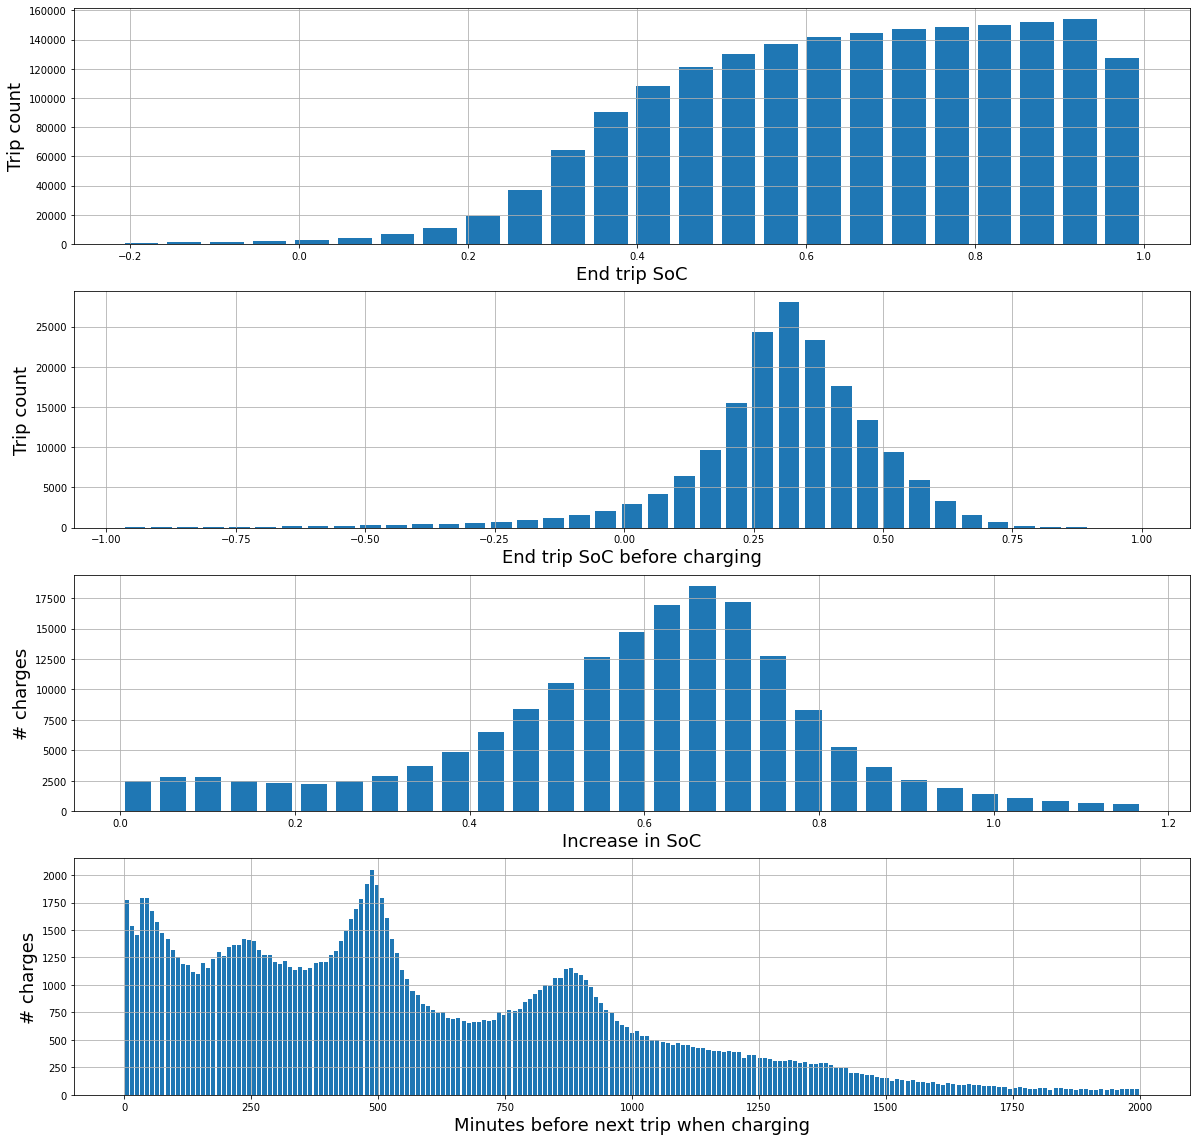

In [70]:
#print("Average % of failed trips: ",round(nbFailedTrips/nbTrips*100,2))

fig, axes = plt.subplots(nrows=4, ncols=1)
fig.set_figheight(20)
fig.set_figwidth(20)

#Distribution of end battery level
ax0 = axes[0]
ax0.bar((bins_endTripSoC[1:] + bins_endTripSoC[:-1])/2,hist_endTripSoC,width=0.04)
ax0.set_xlabel("End trip SoC",fontsize=18)
ax0.set_ylabel("Trip count",fontsize=18)
ax0.grid(True)

#Distribution of SoC when charging
ax1 = axes[1]
ax1.bar((bins_endTripSoC_beforeCharging[1:]+bins_endTripSoC_beforeCharging[:-1])/2,hist_endTripSoC_beforeCharging,width=0.04)
ax1.set_xlabel("End trip SoC before charging",fontsize=18)
ax1.set_ylabel("Trip count",fontsize=18)
ax1.grid(True)

#Distribution of charge
ax2= axes[2]
ax2.bar((bins_increaseInSoC[1:]+bins_increaseInSoC[:-1])/2,hist_increaseInSoC,width=0.03)
ax2.set_xlabel("Increase in SoC",fontsize=18)
ax2.set_ylabel("# charges",fontsize=18)
ax2.grid(True)

#Distribution of minutes between trip when charging
ax3= axes[3]
ax3.bar((bins_minutesWhenCharging[1:] + bins_minutesWhenCharging[:-1])/2,hist_minutesWhenCharging,width=8)
ax3.set_xlabel("Minutes before next trip when charging",fontsize=18)
ax3.set_ylabel("# charges",fontsize=18)
ax3.grid(True)


### Following code works only for one iteration

The trips end with negative battery level for 0.55 % trips


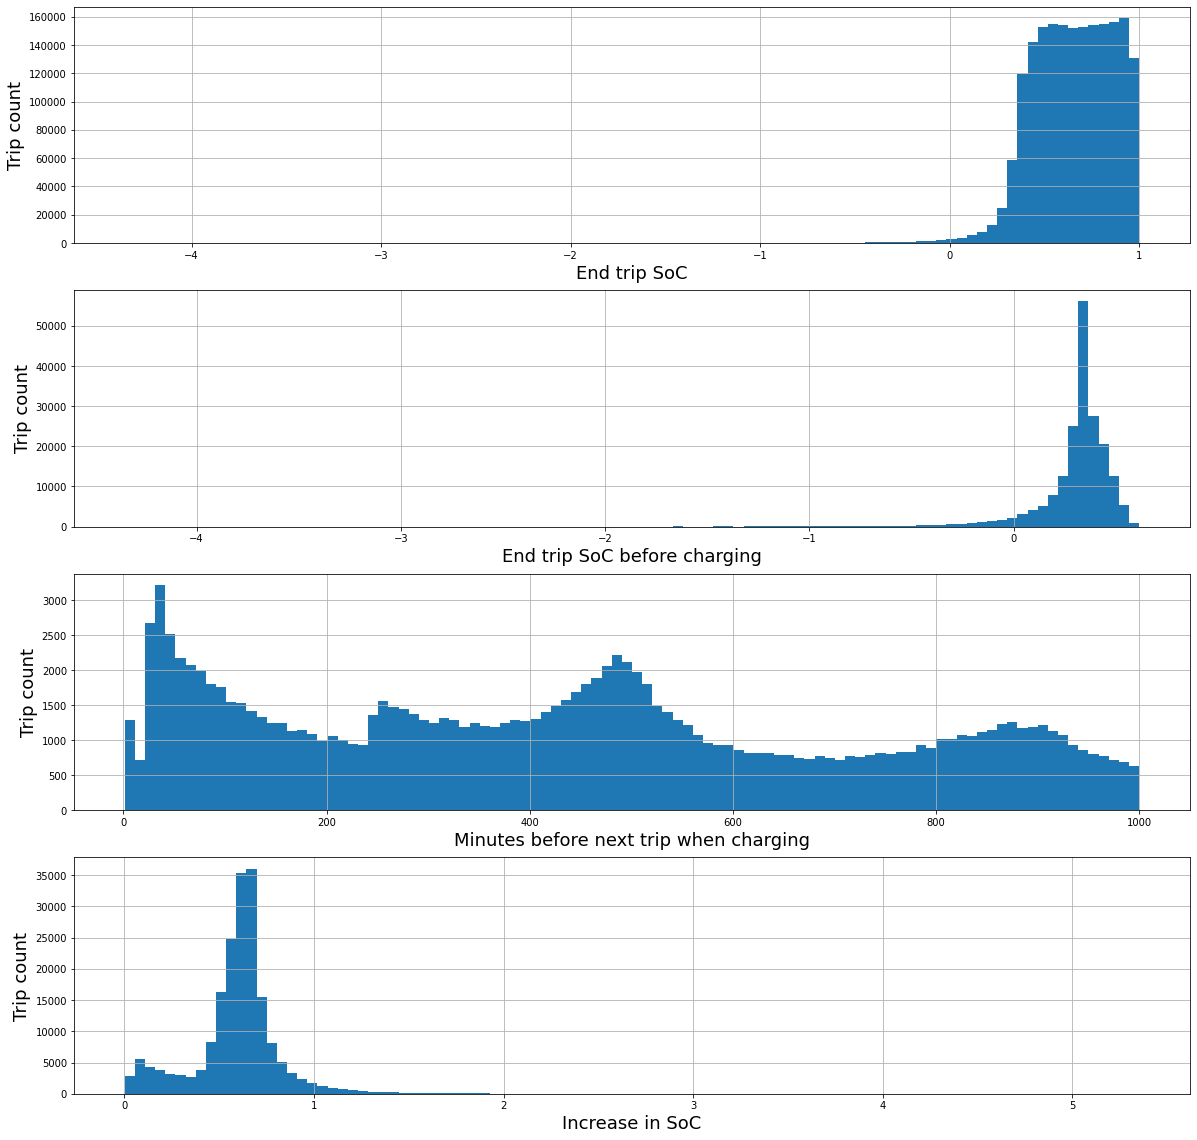

In [71]:
#Careful the start battery level has to be removed from the energy charged as energy charge includes the start battery lvl
df['endBatteryLvl'] = endTripEnergyLvl_beforeCharge
df['endTripSoC'] = endTripEnergyLvl_beforeCharge / batteryCapacity
df['chargeDoneAfterTrip'] = energyChargedAfterTrip>0
df['minutesAfterTrip'] = minutesAfterTrip
df['increaseInSoC'] = energyChargedAfterTrip / batteryCapacity

plotEndBatteryAndMinutesBetweenTripsDistribution(df,'endBatteryLvl','endTripSoC','minutesAfterTrip',\
                                                     'chargeDoneAfterTrip','increaseInSoC')

# Check the standard deviation of demand vs the demand for each EV demand point

In [62]:
df_results = pd.read_pickle('data/Simulation/results_' + str(nbIter)+ 'Iterations')

In [63]:
#Get the sum demand and sum of squared demand
sumDemand = df_results.sumDemand.values
sumSquaredDemand = df_results.sumSquaredDemand.values

#Compute the mean demand
meanDemandByLocation = sumDemand / nbIter

#Compute the std
varDemandByLocation = sumSquaredDemand / nbIter - np.square(sumDemand / nbIter)
varDemandByLocation = np.where(varDemandByLocation<0,0,varDemandByLocation) #Assign null values for values that are slightly negative due to precision
stdDemandByLocation = np.sqrt(varDemandByLocation)

#Compute the ratio std / mean
ratioStdVsDemandByLocation = stdDemandByLocation / np.where(meanDemandByLocation==0,1,meanDemandByLocation)

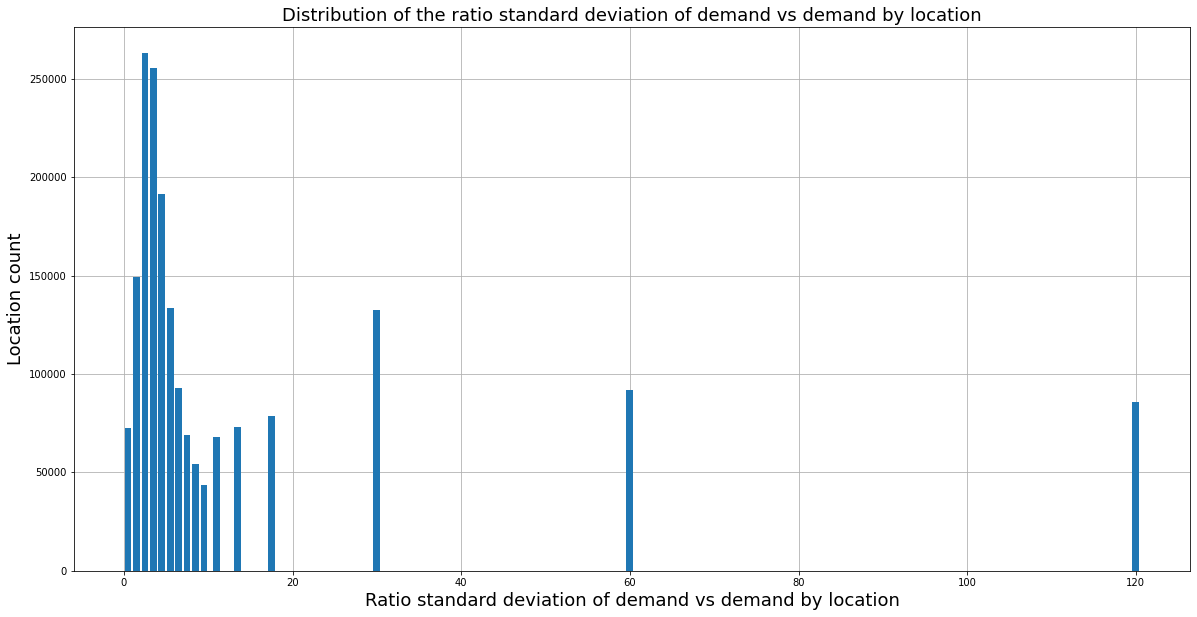

In [64]:
#Plot the distribution for std vs mean
counts,labels = np.histogram(ratioStdVsDemandByLocation, bins=[0,1,2,3,4,5,6,7,8,9,10,12,15,20, 40, 80, 160])

labels = (labels[:-1] + labels[1:])/2

plotHistogram(counts,labels,'Distribution of the ratio standard deviation of demand vs demand by location',
                   'Ratio standard deviation of demand vs demand by location','Location count')